In [145]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np

%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 10)

In [146]:
np.random.seed(7)

In [147]:
# number of features used in the regression
window_size = 10

# lstm_num_timesteps
lstm_num_timesteps = 10
# whether to use LSTM or MLP
use_LSTM = True
# lstm_num_features
lstm_num_features = 1
# stateful?
lstm_stateful = False
# shuffle?
lstm_shuffle = True

batch_size = 1
num_epochs = 2

# scale the dataset to values between scale_min and scale_max
scale = True
scale_min = -1
scale_max = 1

In [148]:
# load the dataset
#df_train = pd.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
df_train = pd.read_csv('108_7_3.train.csv', usecols=[1], engine='python', skipfooter=3)
ts_train = df_train.values.astype('float64')
df_test = pd.read_csv('108_7_3.test.csv', usecols=[1], engine='python', skipfooter=3)
ts_test = df_test.values.astype('float64')
ts_all = np.append(ts_train, ts_test).reshape(-1,1)
len_overall = len(ts_all)

In [149]:
#for testing
#ts_train = np.arange(1,101, dtype='float64').reshape(-1,1)  
#ts_test = np.arange(101,121, dtype='float64').reshape(-1,1)
#window_size = 5
#ts_all = np.append(ts_train, ts_test).reshape(-1,1)
#len_overall = len(ts_all)

In [150]:
len_overall

983

In [151]:
ts_all.dtype

dtype('float64')

In [152]:
ts_train.shape, ts_test.shape

((896, 1), (87, 1))

In [153]:
ts_train[:10]

array([[ 4164.],
       [ 3540.],
       [ 3560.],
       [ 3094.],
       [ 3658.],
       [ 3049.],
       [ 3526.],
       [ 3290.],
       [ 4447.],
       [ 2305.]])

In [154]:
ts_test[:10]

array([[ 1131.],
       [  816.],
       [ 1084.],
       [ 1283.],
       [ 1363.],
       [ 1060.],
       [ 1272.],
       [  636.],
       [ 1095.],
       [ 1284.]])

In [155]:
if scale:
    scaler = MinMaxScaler(feature_range=(scale_min, scale_max))
    ts_train = scaler.fit_transform(ts_train)
    ts_test = scaler.transform(ts_test)

In [156]:
scaler.data_min_, scaler.data_max_

(array([ 322.]), array([ 4749.]))

In [157]:
ts_train[:10]

array([[ 0.73571267],
       [ 0.45380619],
       [ 0.46284165],
       [ 0.25231534],
       [ 0.50711543],
       [ 0.23198554],
       [ 0.44748136],
       [ 0.34086289],
       [ 0.86356449],
       [-0.10413372]])

In [158]:
ts_test[:10]

array([[-0.63451547],
       [-0.77682403],
       [-0.65574881],
       [-0.56584595],
       [-0.52970409],
       [-0.66659137],
       [-0.57081545],
       [-0.85814321],
       [-0.65077931],
       [-0.56539417]])

In [159]:
# split into train and test sets
#train_size = int(len(ts) * 0.67)
#test_size = len(ts) - train_size
#ts_train, ts_test = ts[0:train_size,:], ts[train_size:len(ts),:]
#print(len(ts_train), len(ts_test))


In [160]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, window_size):
    dataX, dataY = [], []
    for i in range(len(dataset) - window_size):
        a = dataset[i:(i + window_size), 0]
        dataX.append(a)
        dataY.append(dataset[i + window_size, 0])
    return np.array(dataX), np.array(dataY)

In [161]:
X_train, y_train = create_dataset(ts_train, window_size)
X_test, y_test = create_dataset(ts_test, window_size)
# the train and test matrices end up shorter than the respective timeseries by window_size + 1!
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((886, 10), (77, 10), (886,), (77,))

In [162]:
X_train[:5,:]

array([[ 0.73571267,  0.45380619,  0.46284165,  0.25231534,  0.50711543,
         0.23198554,  0.44748136,  0.34086289,  0.86356449, -0.10413372],
       [ 0.45380619,  0.46284165,  0.25231534,  0.50711543,  0.23198554,
         0.44748136,  0.34086289,  0.86356449, -0.10413372,  0.05489044],
       [ 0.46284165,  0.25231534,  0.50711543,  0.23198554,  0.44748136,
         0.34086289,  0.86356449, -0.10413372,  0.05489044,  0.11226564],
       [ 0.25231534,  0.50711543,  0.23198554,  0.44748136,  0.34086289,
         0.86356449, -0.10413372,  0.05489044,  0.11226564,  0.24056923],
       [ 0.50711543,  0.23198554,  0.44748136,  0.34086289,  0.86356449,
        -0.10413372,  0.05489044,  0.11226564,  0.24056923,  0.6778857 ]])

In [163]:
y_train[:5]

array([ 0.05489044,  0.11226564,  0.24056923,  0.6778857 ,  0.17957985])

In [164]:
X_test[:5,:]

array([[-0.63451547, -0.77682403, -0.65574881, -0.56584595, -0.52970409,
        -0.66659137, -0.57081545, -0.85814321, -0.65077931, -0.56539417],
       [-0.77682403, -0.65574881, -0.56584595, -0.52970409, -0.66659137,
        -0.57081545, -0.85814321, -0.65077931, -0.56539417, -0.62909419],
       [-0.65574881, -0.56584595, -0.52970409, -0.66659137, -0.57081545,
        -0.85814321, -0.65077931, -0.56539417, -0.62909419, -0.68601762],
       [-0.56584595, -0.52970409, -0.66659137, -0.57081545, -0.85814321,
        -0.65077931, -0.56539417, -0.62909419, -0.68601762, -0.55590693],
       [-0.52970409, -0.66659137, -0.57081545, -0.85814321, -0.65077931,
        -0.56539417, -0.62909419, -0.68601762, -0.55590693, -0.73480913]])

In [165]:
y_test[:5]

array([-0.62909419, -0.68601762, -0.55590693, -0.73480913, -0.84730066])

In [166]:
if use_LSTM:
    # reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], lstm_num_timesteps, lstm_num_features))
    X_test = np.reshape(X_test, (X_test.shape[0], lstm_num_timesteps, lstm_num_features))

In [167]:
model = Sequential()

if use_LSTM:
    model.add(LSTM(4, input_dim=lstm_num_features))
else:
    model.add(Dense(8, input_dim=window_size, activation='relu'))
    
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

if use_LSTM:
    hist = model.fit(X_train, y_train, nb_epoch=num_epochs, batch_size=batch_size)
else:
    hist = model.fit(X_train, y_train, nb_epoch=num_epochs, batch_size=batch_size, verbose = 1)
    
    
#######
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=lstm_shuffle)
		model.reset_states()
	return model

Epoch 1/2
886/886 [==============================] - 12s - loss: 0.0396    
Epoch 2/2
886/886 [==============================] - 11s - loss: 0.0334    


In [168]:
hist.params

{'batch_size': 1,
 'do_validation': False,
 'metrics': ['loss'],
 'nb_epoch': 2,
 'nb_sample': 886,
 'verbose': 1}

In [169]:
model.metrics_names, model.metrics_tensors

(['loss'], [])

In [170]:
model.evaluate(X_test, y_test, batch_size = X_test.shape[0])

77/77 [==============================] - 0s


0.01828649640083313

In [171]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [172]:
y_train[:10],pred_train[:10,0]

(array([ 0.05489044,  0.11226564,  0.24056923,  0.6778857 ,  0.17957985,
         1.        ,  0.64942399,  0.23243732,  0.2613508 ,  0.47820194]),
 array([ 0.19429353,  0.18644124,  0.19592005,  0.20803422,  0.22026816,
         0.2172339 ,  0.21330166,  0.2063874 ,  0.1820372 ,  0.14347023], dtype=float32))

In [173]:
y_test[:10],pred_test[:10,0]

(array([-0.62909419, -0.68601762, -0.55590693, -0.73480913, -0.84730066,
        -0.4705218 , -0.69053535, -0.69866727, -0.6914389 , -0.48994805]),
 array([-0.57083225, -0.57206643, -0.5726825 , -0.56156969, -0.57677346,
        -0.5967083 , -0.57073742, -0.58382326, -0.57977384, -0.58130175], dtype=float32))

In [174]:
if scale:
    pred_train = scaler.inverse_transform(pred_train)
    y_train = scaler.inverse_transform(y_train.reshape(-1,1)))
    pred_test = scaler.inverse_transform(pred_test)
    y_test = scaler.inverse_transform(y_test.reshape(-1,1)))


/home/key/software/anaconda3/envs/tf3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/key/software/anaconda3/envs/tf3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [176]:
y_train[:10],pred_train[:10,0]

(array([ 2657.,  2784.,  3068.,  4036.,  2933.,  4749.,  3973.,  3050.,
         3114.,  3594.]),
 array([ 2965.56860352,  2948.1875    ,  2969.16894531,  2995.98364258,
         3023.06347656,  3016.34716797,  3007.64331055,  2992.33862305,
         2938.43945312,  2853.07128906], dtype=float32))

In [177]:
# calculate root mean squared error
rsme_train = math.sqrt(mean_squared_error(y_train, pred_train[:,0]))
print('Train Score: %.2f RMSE' % (rsme_train))
rsme_test = math.sqrt(mean_squared_error(y_test, pred_test[:,0]))
print('Test Score: %.2f RMSE' % (rsme_test))

Train Score: 396.97 RMSE
Test Score: 299.33 RMSE


In [178]:
print(len(ts_train), len(pred_train), len(y_train))
len(ts_test), len(pred_test), len(y_test) 

896 886 886


(87, 77, 77)

In [180]:
# shift train predictions for plotting
pred_train_shifted = np.empty_like(ts_all)
print(pred_train_shifted.size)
pred_train_shifted[:, :] = np.nan
# train predictions start at position window_size + 1 (or window_size, if counting from 0)
pred_train_shifted[window_size : len(pred_train) + window_size, :] = pred_train
pred_train_shifted[:13]

983


array([[           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [           nan],
       [ 2965.56860352],
       [ 2948.1875    ],
       [ 2969.16894531]])

In [181]:
# shift test predictions for plotting
pred_test_shifted = np.empty_like(ts_all)
pred_test_shifted[:, :] = np.nan
pred_test_shifted[len(pred_train) + (window_size * 2) : len_overall + 1, :] = pred_test
pred_test_shifted[-13:]

array([[ 1184.87341309],
       [ 1195.46105957],
       [ 1235.58105469],
       [ 1208.41564941],
       [ 1182.91772461],
       [ 1221.85205078],
       [ 1202.9107666 ],
       [ 1238.75732422],
       [ 1206.2677002 ],
       [ 1257.22302246],
       [ 1237.73803711],
       [ 1220.53771973],
       [ 1216.40478516]])

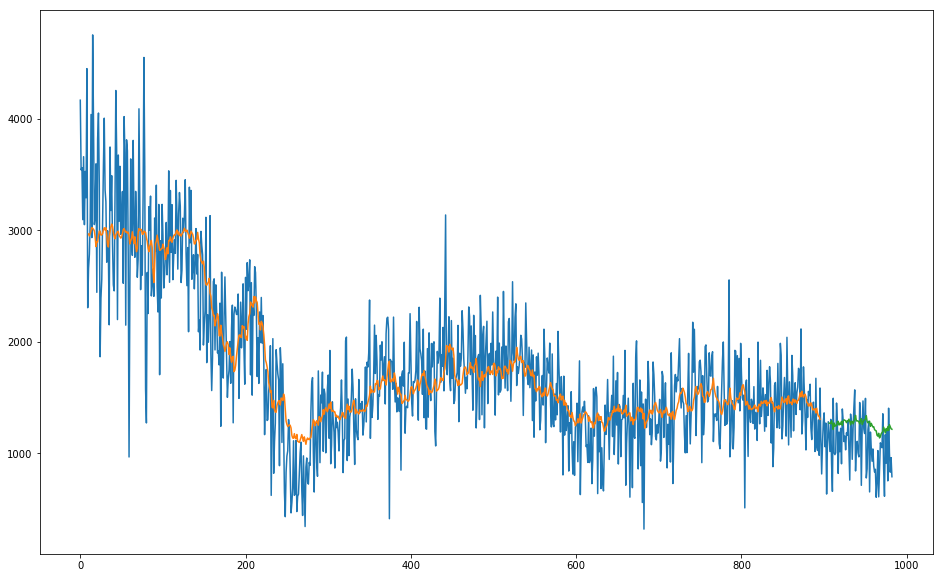

In [182]:
plt.plot(ts_all)
plt.plot(pred_train_shifted)
plt.plot(pred_test_shifted)
plt.show()